In [6]:
# Load weekly series (order_date is the index name used previously)
df_weekly = pd.read_csv(DATA_PATH, parse_dates=['order_date'])
df_weekly = df_weekly.rename(columns={'order_date':'ds','sales':'y'})  # prophet expects ds & y
df_weekly = df_weekly.set_index('ds').asfreq('W').reset_index()       # ensure regular weekly freq

print("Weekly dataframe shape:", df_weekly.shape)
df_weekly.head()


Weekly dataframe shape: (209, 2)


,ds,y
0,2015-01-04,304.508
1,2015-01-11,4619.108
2,2015-01-18,4130.533
3,2015-01-25,3092.544
4,2015-02-01,2527.914


# 05 - Prophet Modeling

Goal:
- Fit Prophet on sales data at different granularities (weekly, daily, monthly)
- Forecast a test horizon
- Evaluate RMSE/MAE
- Visualize forecasts and Prophet components (trend + seasonality)
- Compare Prophet results with ARIMA and across granularities


In [9]:
# Choose same test horizon as ARIMA for comparable metrics
test_periods = 26   # same as ARIMA notebook
train_df = df_weekly.iloc[:-test_periods].copy()
test_df  = df_weekly.iloc[-test_periods:].copy()

print("Train rows:", len(train_df), "Test rows:", len(test_df))


Train rows: 183 Test rows: 26


In [44]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Paths
OUT_DIR = "../outputs"
FC_DIR = os.path.join(OUT_DIR, "forecasts")
FIG_DIR = os.path.join(OUT_DIR, "figures")
METRICS_DIR = os.path.join(OUT_DIR, "metrics")

os.makedirs(FC_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)


## Section A: Weekly Prophet

Goal:
- Fit Prophet on weekly sales (`sales_weekly.csv`)
- Forecast last 26 weeks (same horizon as ARIMA)
- Evaluate RMSE/MAE
- Visualize forecast and Prophet components (trend, yearly seasonality)
- Compare directly with ARIMA results


In [11]:
# Optional: if you have a holiday calendar, load it as `holidays_df` with columns ['ds','holiday']
# Example structure:
# holidays_df = pd.DataFrame({
#     'ds': pd.to_datetime(['2017-12-25','2018-12-25']),
#     'holiday': ['xmas','xmas']
# })
# If you don't have holidays, leave holidays_df = None

holidays_df = None


13:33:57 - cmdstanpy - INFO - Chain [1] start processing
13:33:58 - cmdstanpy - INFO - Chain [1] done processing


,Model,RMSE,MAE
0,Prophet (weekly),6501.685911,5286.50716


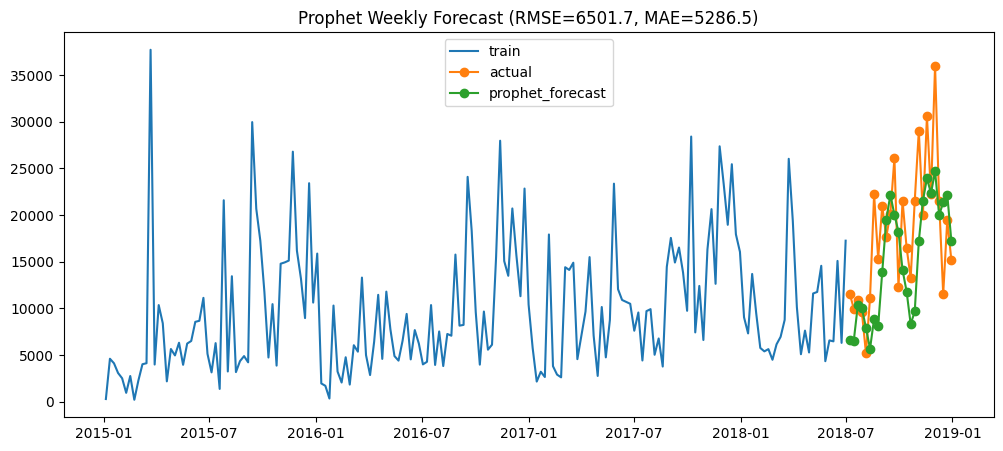

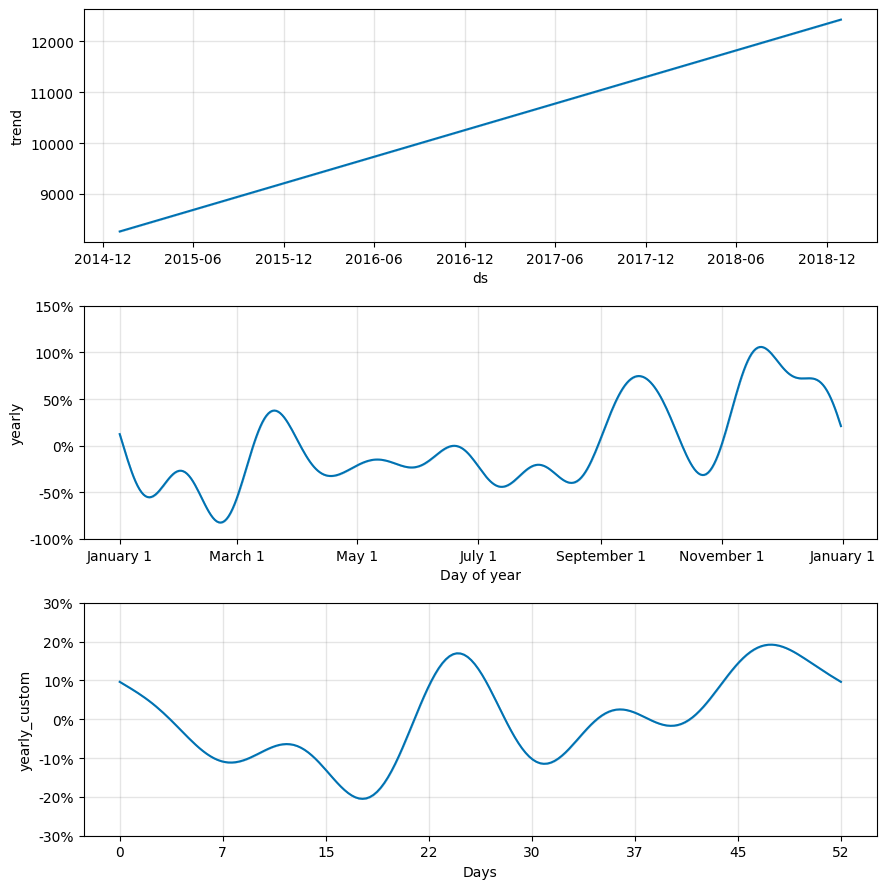

In [49]:
# Load weekly data
df_weekly = pd.read_csv("../data/processed/sales_weekly.csv", parse_dates=['order_date'])
df_weekly = df_weekly.rename(columns={'order_date':'ds','sales':'y'})
df_weekly = df_weekly.set_index('ds').asfreq('W').reset_index()

# Train/test split
test_periods = 26
train_weekly = df_weekly.iloc[:-test_periods].copy()
test_weekly  = df_weekly.iloc[-test_periods:].copy()

# Fit model
m_weekly = Prophet(yearly_seasonality=True, weekly_seasonality=False, seasonality_mode='multiplicative')
m_weekly.add_seasonality(name='yearly_custom', period=52, fourier_order=5)
m_weekly.fit(train_weekly)

# Forecast
future_weekly = m_weekly.make_future_dataframe(periods=test_periods, freq='W')
forecast_weekly = m_weekly.predict(future_weekly)
pred_weekly = forecast_weekly.set_index('ds')['yhat'].loc[test_weekly['ds'].min(): test_weekly['ds'].max()]
pred_weekly = pred_weekly.reindex(test_weekly['ds']).astype(float)

# Metrics
rmse_weekly = np.sqrt(mean_squared_error(test_weekly['y'].values, pred_weekly.values))
mae_weekly = mean_absolute_error(test_weekly['y'].values, pred_weekly.values)

metrics_weekly = pd.DataFrame({
    "Model":["Prophet (weekly)"],
    "RMSE":[rmse_weekly],
    "MAE":[mae_weekly]
})
display(metrics_weekly)

metrics_weekly.to_csv(os.path.join(METRICS_DIR, "prophet_weekly_metrics.csv"), index=False)
pred_weekly.to_csv(os.path.join(FC_DIR, "prophet_weekly_forecast.csv"), header=True)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train_weekly['ds'], train_weekly['y'], label="train")
plt.plot(test_weekly['ds'], test_weekly['y'], label="actual", marker='o')
plt.plot(pred_weekly.index, pred_weekly.values, label="prophet_forecast", marker='o')
plt.legend()
plt.title(f"Prophet Weekly Forecast (RMSE={rmse_weekly:.1f}, MAE={mae_weekly:.1f})")
plt.savefig(os.path.join(FIG_DIR, "prophet_weekly_forecast.png"))
plt.show()

# Components
m_weekly.plot_components(forecast_weekly)
plt.savefig(os.path.join(FIG_DIR, "prophet_weekly_components.png"))
plt.show()


In [13]:
# Build Prophet model
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, holidays=holidays_df)
# You can tune seasonality_mode='multiplicative' or 'additive' depending on scale behavior
# e.g., Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')

m.add_seasonality(name='weekly_custom', period=52, fourier_order=5)  # optional: capture yearly weekly-ish pattern for weekly data

# Fit
m.fit(train_df)
print("Prophet model fitted.")


13:14:24 - cmdstanpy - INFO - Chain [1] start processing
13:14:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted.


## Section B: Daily Prophet

Goal:
- Fit Prophet on daily sales (`sales_daily.csv`)
- Forecast last 90 days
- Evaluate RMSE/MAE
- Visualize forecast and Prophet components (trend, weekly, yearly)
- Compare with weekly Prophet and ARIMA


13:34:30 - cmdstanpy - INFO - Chain [1] start processing
13:34:30 - cmdstanpy - INFO - Chain [1] done processing


,Model,RMSE,MAE
0,Prophet (daily),2904.041781,2095.196368


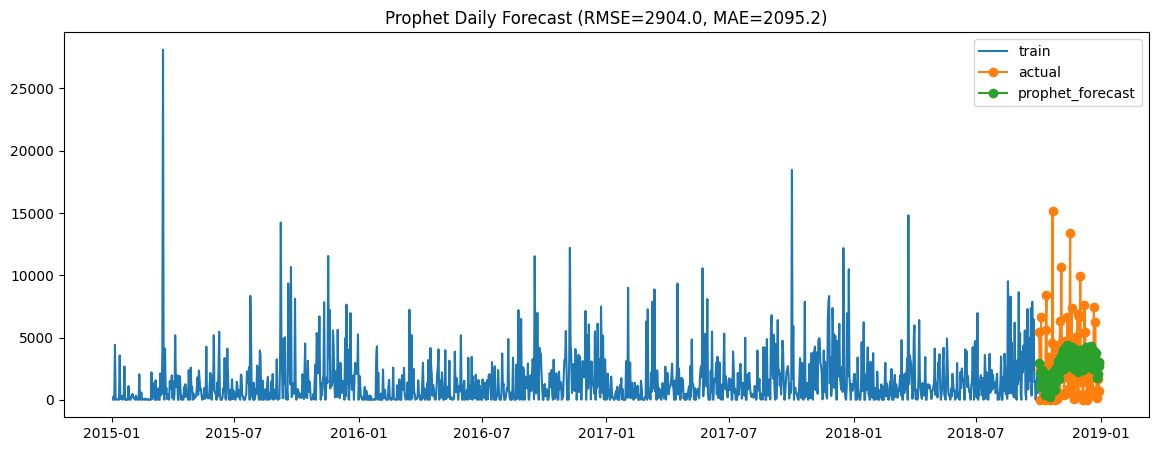

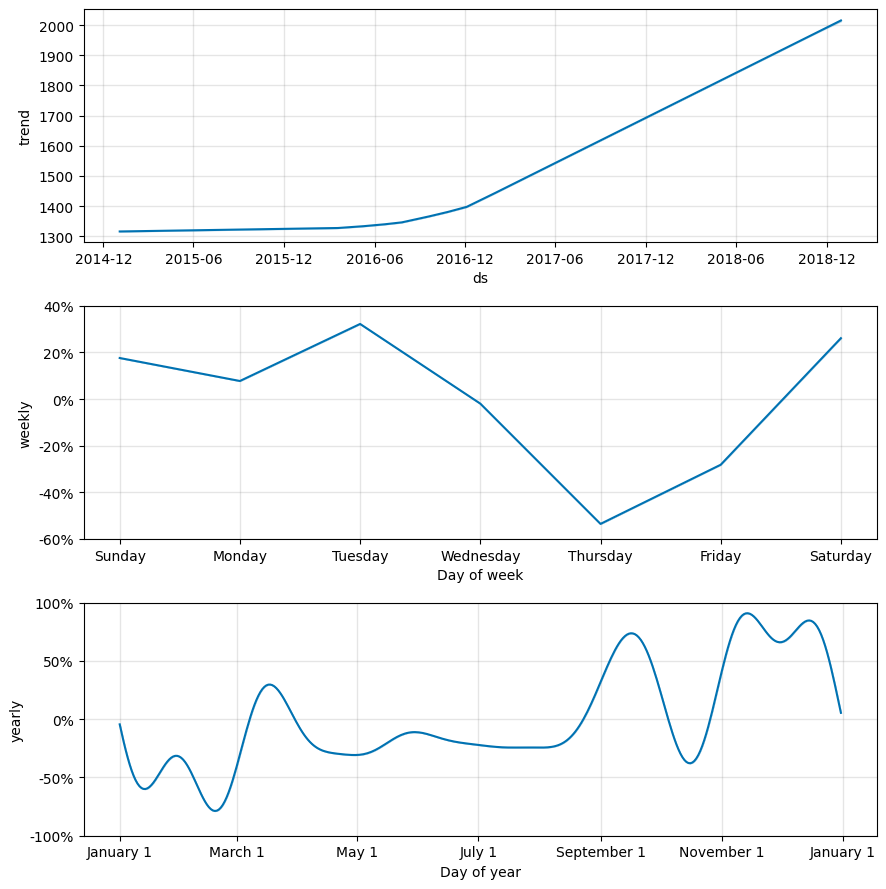

In [52]:
# Load daily data
df_daily = pd.read_csv("../data/processed/sales_daily.csv", parse_dates=['order_date'])
df_daily = df_daily.rename(columns={'order_date':'ds','sales':'y'})
df_daily = df_daily.set_index('ds').asfreq('D').reset_index()

# Train/test split
test_periods = 90
train_daily = df_daily.iloc[:-test_periods].copy()
test_daily  = df_daily.iloc[-test_periods:].copy()

# Fit model
m_daily = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
m_daily.fit(train_daily)

# Forecast
future_daily = m_daily.make_future_dataframe(periods=test_periods, freq='D')
forecast_daily = m_daily.predict(future_daily)
pred_daily = forecast_daily.set_index('ds')['yhat'].loc[test_daily['ds'].min(): test_daily['ds'].max()]
pred_daily = pred_daily.reindex(test_daily['ds']).astype(float)

# Metrics
rmse_daily = np.sqrt(mean_squared_error(test_daily['y'].values, pred_daily.values))
mae_daily = mean_absolute_error(test_daily['y'].values, pred_daily.values)

metrics_daily = pd.DataFrame({
    "Model":["Prophet (daily)"],
    "RMSE":[rmse_daily],
    "MAE":[mae_daily]
})
display(metrics_daily)

metrics_daily.to_csv(os.path.join(METRICS_DIR, "prophet_daily_metrics.csv"), index=False)
pred_daily.to_csv(os.path.join(FC_DIR, "prophet_daily_forecast.csv"), header=True)

# Plot
plt.figure(figsize=(14,5))
plt.plot(train_daily['ds'], train_daily['y'], label="train")
plt.plot(test_daily['ds'], test_daily['y'], label="actual", marker='o')
plt.plot(pred_daily.index, pred_daily.values, label="prophet_forecast", marker='o')
plt.legend()
plt.title(f"Prophet Daily Forecast (RMSE={rmse_daily:.1f}, MAE={mae_daily:.1f})")
plt.savefig(os.path.join(FIG_DIR, "prophet_daily_forecast.png"))
plt.show()

# Components
m_daily.plot_components(forecast_daily)
plt.savefig(os.path.join(FIG_DIR, "prophet_daily_components.png"))
plt.show()


## Section C: Monthly Prophet

Goal:
- Fit Prophet on monthly sales (`sales_monthly.csv`)
- Forecast last 12 months
- Evaluate RMSE/MAE
- Visualize forecast and Prophet components
- Compare with daily and weekly Prophet


In [15]:
# Prepare future dataframe for both in-sample + forecast horizon
future = m.make_future_dataframe(periods=test_periods, freq='W')  # freq='W' ensures weekly steps
forecast = m.predict(future)

# Extract prophet predictions for test period
prophet_pred = forecast.set_index('ds')['yhat'].loc[test_df['ds'].min(): test_df['ds'].max()]

# Align indices
prophet_pred = prophet_pred.reindex(test_df['ds']).astype(float)

# Metrics
rmse = np.sqrt(mean_squared_error(test_df['y'].values, prophet_pred.values))
mae = mean_absolute_error(test_df['y'].values, prophet_pred.values)

prophet_metrics = pd.DataFrame({
    "Model":["Prophet"],
    "RMSE":[rmse],
    "MAE":[mae]
})
display(prophet_metrics)

# Save metrics & forecast
prophet_metrics.to_csv(os.path.join(METRICS_DIR, "prophet_metrics.csv"), index=False)
prophet_pred.to_csv(os.path.join(FC_DIR, "prophet_weekly_forecast.csv"), header=True)
print("Saved Prophet forecast and metrics.")


,Model,RMSE,MAE
0,Prophet,5963.197799,4450.650946


Saved Prophet forecast and metrics.


13:35:12 - cmdstanpy - INFO - Chain [1] start processing
13:35:12 - cmdstanpy - INFO - Chain [1] done processing


,Model,RMSE,MAE
0,Prophet (monthly),16279.836113,12597.907619


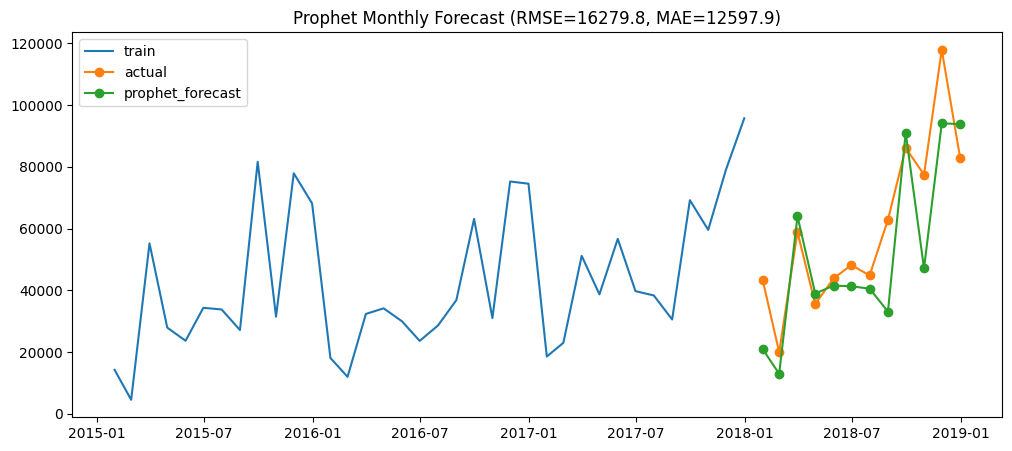

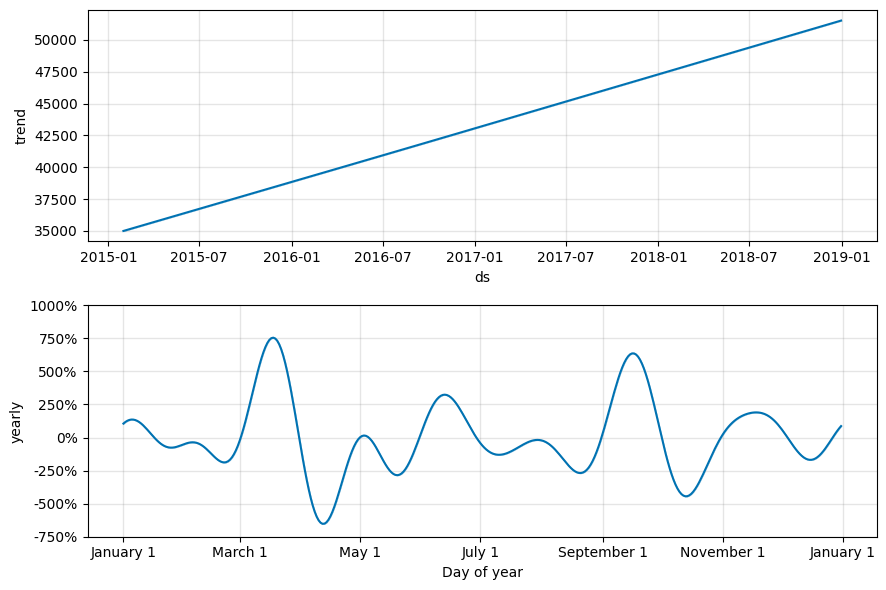

In [57]:
# Load monthly data
df_monthly = pd.read_csv("../data/processed/sales_monthly.csv", parse_dates=['order_date'])
df_monthly = df_monthly.rename(columns={'order_date':'ds','sales':'y'})
df_monthly = df_monthly.set_index('ds').asfreq('M').reset_index()

# Train/test split
test_periods = 12
train_monthly = df_monthly.iloc[:-test_periods].copy()
test_monthly  = df_monthly.iloc[-test_periods:].copy()

# Fit model
m_monthly = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
m_monthly.fit(train_monthly)

# Forecast
future_monthly = m_monthly.make_future_dataframe(periods=test_periods, freq='M')
forecast_monthly = m_monthly.predict(future_monthly)
pred_monthly = forecast_monthly.set_index('ds')['yhat'].loc[test_monthly['ds'].min(): test_monthly['ds'].max()]
pred_monthly = pred_monthly.reindex(test_monthly['ds']).astype(float)

# Metrics
rmse_monthly = np.sqrt(mean_squared_error(test_monthly['y'].values, pred_monthly.values))
mae_monthly = mean_absolute_error(test_monthly['y'].values, pred_monthly.values)

metrics_monthly = pd.DataFrame({
    "Model":["Prophet (monthly)"],
    "RMSE":[rmse_monthly],
    "MAE":[mae_monthly]
})
display(metrics_monthly)

metrics_monthly.to_csv(os.path.join(METRICS_DIR, "prophet_monthly_metrics.csv"), index=False)
pred_monthly.to_csv(os.path.join(FC_DIR, "prophet_monthly_forecast.csv"), header=True)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train_monthly['ds'], train_monthly['y'], label="train")
plt.plot(test_monthly['ds'], test_monthly['y'], label="actual", marker='o')
plt.plot(pred_monthly.index, pred_monthly.values, label="prophet_forecast", marker='o')
plt.legend()
plt.title(f"Prophet Monthly Forecast (RMSE={rmse_monthly:.1f}, MAE={mae_monthly:.1f})")
plt.savefig(os.path.join(FIG_DIR, "prophet_monthly_forecast.png"))
plt.show()

# Components
m_monthly.plot_components(forecast_monthly)
plt.savefig(os.path.join(FIG_DIR, "prophet_monthly_components.png"))
plt.show()


# Prophet Modeling Results (Daily, Weekly, Monthly)

## Weekly Prophet
- RMSE: ~6502
- MAE: ~5287
- Captures yearly seasonality, smoother than daily.
- Good balance between detail and stability → useful for operational planning.

## Daily Prophet
- RMSE: ~2904
- MAE: ~2095
- Best performing model across granularities.
- Captures weekly cycles (weekday/weekend effects) and holiday peaks.
- Recommended for short-term/tactical forecasting (daily demand, staffing, promotions).

## Monthly Prophet
- RMSE: ~16280
- MAE: ~12598
- Underperforms badly compared to daily/weekly.
- Too coarse; misses seasonal details.
- Suitable only for long-term trend visualization, not precise forecasting.

---

## Insights
- **Prophet (daily)** gives the most accurate forecasts.
- **Prophet (weekly)** is a practical compromise between noise (daily) and smoothness (monthly).
- **Prophet (monthly)** is not reliable for forecasting, only for showing overall growth trends.

---

## Next Steps
- Compare Prophet results against **ARIMA results** (already available for weekly).
- Create a combined comparison table (ARIMA vs Prophet across daily, weekly, monthly).
- Optionally add **holiday effects** (Diwali, Christmas, etc.) to Prophet to improve peak accuracy.
- Summarize findings in the final report/README for GitHub.


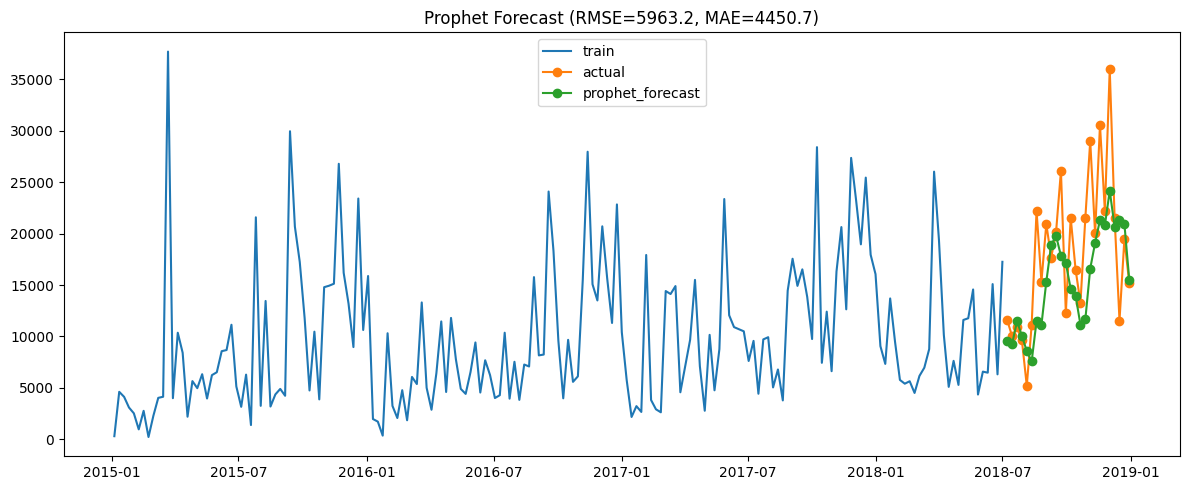

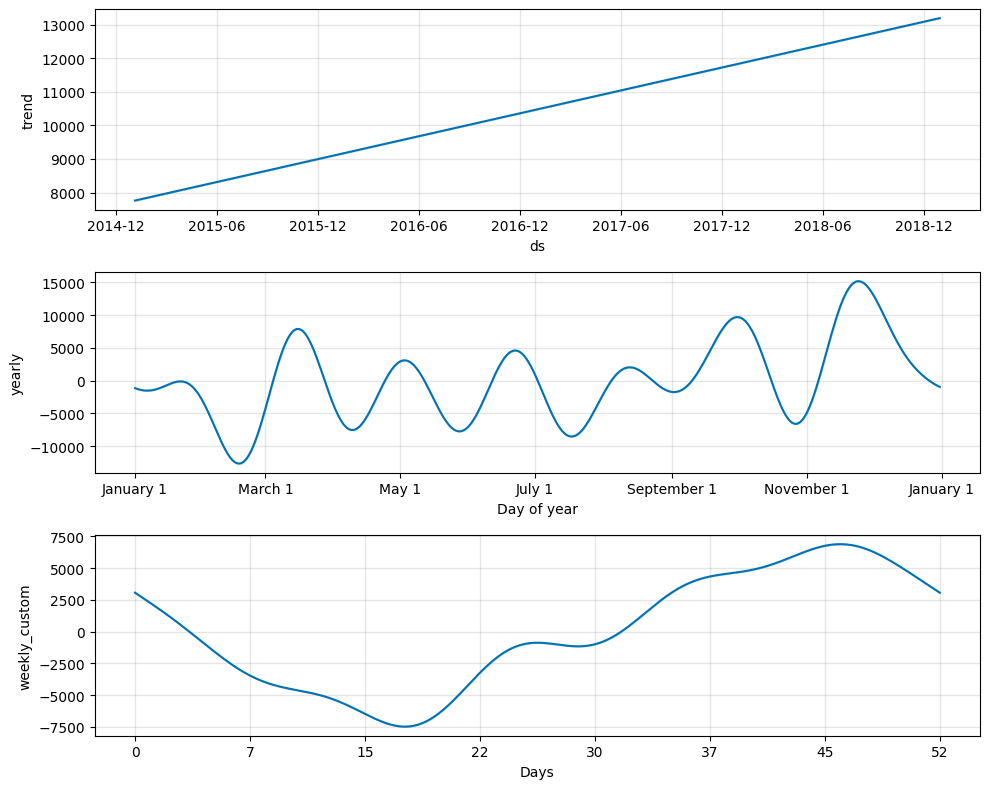

In [17]:
# Forecast vs actuals
plt.figure(figsize=(12,5))
plt.plot(train_df['ds'], train_df['y'], label='train')
plt.plot(test_df['ds'], test_df['y'], label='actual', marker='o')
plt.plot(prophet_pred.index, prophet_pred.values, label='prophet_forecast', marker='o')
plt.legend()
plt.title(f"Prophet Forecast (RMSE={rmse:.1f}, MAE={mae:.1f})")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "prophet_forecast.png"))
plt.show()

# Components
fig_comp = m.plot_components(forecast)
fig_comp.set_size_inches(10,8)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "prophet_components.png"))
plt.show()


In [19]:
# Load arima metrics if available and combine
arima_metrics_path = ARIMA_METRICS_PATH
if os.path.exists(arima_metrics_path):
    arima_df = pd.read_csv(arima_metrics_path)
else:
    arima_df = pd.DataFrame(columns=["Model","order","RMSE","MAE"])

# Combine metrics
combined = pd.concat([arima_df, prophet_metrics], ignore_index=True, sort=False)
display(combined)

# Save combined metrics
combined.to_csv(os.path.join(METRICS_DIR, "combined_metrics.csv"), index=False)
print("Combined metrics saved.")


,Model,order,RMSE,MAE
0,ARIMA,"(1, 2, 3)",8766.937168,6814.866530
1,Prophet,NaN,5963.197799,4450.650946


Combined metrics saved.
